A notebook to explore different ways of binning the skill scores.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import datetime
import dateutil

from datetime import timedelta

%matplotlib inline

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
ds = xr.open_dataset('/home/soontiensn/data/gpsc-work2/OPP/SalishSea-N08/hourly-windage2/all_output/output_per_drifter/P2D-wp4372522492D20160617_aggregated.nc')
ds

<xarray.Dataset>
Dimensions:            (model_run: 24, timestep: 577)
Coordinates:
  * timestep           (timestep) int64 0 1 2 3 4 5 ... 571 572 573 574 575 576
    time               (model_run, timestep) datetime64[ns] ...
Dimensions without coordinates: model_run
Data variables:
    obs_lat            (model_run, timestep) float64 ...
    obs_lon            (model_run, timestep) float64 ...
    mod_lat            (model_run, timestep) float64 ...
    mod_lon            (model_run, timestep) float64 ...
    liu                (model_run, timestep) float64 ...
    molcard            (model_run, timestep) float64 ...
    sep                (model_run, timestep) float64 ...
    obs_dist           (model_run, timestep) float64 ...
    obs_disp           (model_run, timestep) float64 ...
    mod_dist           (model_run, timestep) float64 ...
    mod_disp           (model_run, timestep) float64 ...
    sutherland         (model_run, timestep) float64 ...
    obsratio           (model_

# Investigate data:
Big question: Before we apply any binning/averaging, how many data points are between 47 hours and 48 hours??

1. Count using timedeltas

In [3]:
counts=[]
for m in ds.model_run.values:
    time_since_start = (ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64))
    count = np.count_nonzero(
                np.logical_and(
                    time_since_start.values.astype('timedelta64[s]').astype('float') > 47*3600,
                    time_since_start.values.astype('timedelta64[s]').astype('float') <= 48*3600))
    counts.append(count)
print(counts)

[12, 12, 12, 12, 4, 12, 12, 12, 12, 12, 12, 12, 13, 11, 11, 12, 11, 13, 12, 11, 12, 12, 12, 10]


Try a second way of counting

2. Count using datetime objects

In [4]:
counts =[]
for m in ds.model_run.values:
    start=datetime.datetime.strptime(ds['mod_start_date'].values[m], '%Y-%m-%d %H:%M:%S')
    hour_47 = start + timedelta(hours=47)
    hour_48 = start + timedelta(hours=48)
    time = ds['time'][m,:].values
    time = time[~np.isnat(time)]
    time = np.array([dateutil.parser.parse(time[m].astype('str')) for m in range(len(time))])
    count = np.count_nonzero(np.logical_and(time > hour_47, time <= hour_48) )
    counts.append(count)
print(counts)

[12, 12, 12, 12, 4, 12, 12, 12, 12, 12, 12, 12, 13, 11, 11, 12, 11, 13, 12, 11, 12, 12, 12, 10]


Ok, so I've confirmed two things
1. There are data points in the 47 to 48 hour bin for this drifer, for all runs.
2. I have two different methods that produce the same counts.

This means that the way we are binning right now is incorrect because most of our tracks have no data in the 47 to 48 hour bins. I remember reading something that resampling with timedelta objects can be problematic.


Let's investigate that.

First, copy the bin_skills that we currently have.

In [5]:
def bin_skills(ds, skill, sampling_freq):
    """ bin skill scores by drifter """
    ds['time_since_start'] = ds['time'].astype(np.timedelta64)
    for m in ds.model_run.values:
        ds['time_since_start'][m, :] = ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64) 
    df = ds.to_dataframe()
    df = df.set_index('time_since_start')
    df_res = df[skill].dropna().sort_index().resample(sampling_freq, closed='right', label='right').mean().interpolate()
    df_count = df[skill].dropna().sort_index().resample(sampling_freq, closed='right', label='right').count()
    df_res = df_res.reset_index()
    df_res['count'] = df_count.values
    df_res['hours since start'] = df_res.time_since_start.astype('timedelta64[h]')
    return df_res

Next, make a new bin_skills function the specifies the resampling frequency as a timedelta object rather than a string

In [6]:
def bin_skills_timedelta(ds, skill):
    """ bin skill scores by drifter """
    ds['time_since_start'] = ds['time'].astype(np.timedelta64)
    for m in ds.model_run.values:
        ds['time_since_start'][m, :] = ds['time'][m, :] - ds['mod_start_date'][m].astype(str).astype(np.datetime64) 
    df = ds.to_dataframe()
    df = df.set_index('time_since_start')
    df_res = df[skill].dropna().sort_index().resample(timedelta(hours=1), closed='right', label='right').mean().interpolate()
    df_count = df[skill].dropna().sort_index().resample(timedelta(hours=1), closed='right', label='right').count()
    df_res = df_res.reset_index()
    df_res['count'] = df_count.values
    df_res['hours since start'] = df_res.time_since_start.astype('timedelta64[h]')
    return df_res

Finally, resample using the time as the index. That is, group into hours before caclualting the time since start. To be safe, use the model's start hour as the base (although I'm not sur it's needed).


In [7]:
def bin_skills_time(ds, skill):
    """Calculate average skill scores in hourly bins"""
    df = pd.DataFrame()
    for m in ds.model_run.values:
        start=datetime.datetime.strptime(ds['mod_start_date'].values[m], '%Y-%m-%d %H:%M:%S')
        df_tmp = ds.sel(model_run=m).to_dataframe()
        df_tmp=df_tmp.set_index('time')
        # Need to sum the skill and counts in order to do the average properly
        df_res = df_tmp[skill].dropna().sort_index().resample('1H',closed='right', label='right',
                                                              base=start.hour).sum()
        df_count= df_tmp[skill].dropna().sort_index().resample('1H',closed='right', label='right',
                                                              base=start.hour).count()
        df_res = df_res.reset_index()
        df_res['time_since_start'] = df_res['time'] - start
        df_res['model_run'] = m
        df_res['count'] = df_count.values
        df = pd.concat([df,df_res])
    df_grouped = df.groupby('time_since_start')
    # Now the average is the sum of all the skills over the sum of all the counts
    df_mean = df_grouped.apply(lambda x: pd.Series({skill: x[skill].sum()/x['count'].sum(),
                                                   'count': x['count'].sum()}))
    df_mean = df_mean.reset_index()
    df_mean['hours since start'] = df_mean.time_since_start.astype('timedelta64[h]')
    return df_mean

Now, compare the different methods

In [8]:
df_orig = bin_skills(ds,'sep', '1H')
df_timedelta = bin_skills_timedelta(ds, 'sep')
df_time = bin_skills_time(ds, 'sep')

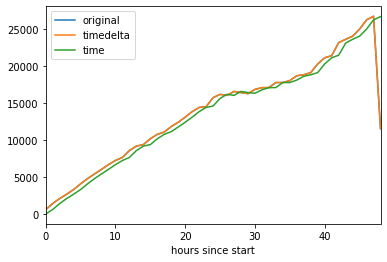

In [9]:
fig,ax=plt.subplots(1,1)
df_orig.plot(x='hours since start', y='sep', ax=ax,label='original')
df_timedelta.plot(x='hours since start', y='sep', ax=ax,label= 'timedelta')
df_time.plot(x='hours since start', y='sep', ax=ax, label='time')

* timedelta method makes no difference.
* Large jump is corrected in the new method.
* Elsewhere, there are minor differences in the average scores. The major differnce is getting the bins where we expect them to be.
* It looks as though the curves are essentially shifted by one hour.

Out of curiosity, I wonder if the orginal way is equivalent to closing the left end point and using left labels. Let's do a quick check.

In [10]:
def bin_skills_time_left(ds, skill):
    """Calculate average skill scores in hourly bins"""
    df = pd.DataFrame()
    for m in ds.model_run.values:
        start=datetime.datetime.strptime(ds['mod_start_date'].values[m], '%Y-%m-%d %H:%M:%S')
        df_tmp = ds.sel(model_run=m).to_dataframe()
        df_tmp=df_tmp.set_index('time')
        # Need to sum the skill and counts in order to do the average properly
        df_res = df_tmp[skill].dropna().sort_index().resample('1H',closed='left', label='left',
                                                              base=start.hour).sum()
        df_count= df_tmp[skill].dropna().sort_index().resample('1H',closed='left', label='left',
                                                              base=start.hour).count()
        df_res = df_res.reset_index()
        df_res['time_since_start'] = df_res['time'] - start
        df_res['model_run'] = m
        df_res['count'] = df_count.values
        df = pd.concat([df,df_res])
    df_grouped = df.groupby('time_since_start')
    # Now the average is the sum of all the skills over the sum of all the counts
    df_mean = df_grouped.apply(lambda x: pd.Series({skill: x[skill].sum()/x['count'].sum(),
                                                   'count': x['count'].sum()}))
    df_mean = df_mean.reset_index()
    df_mean['hours since start'] = df_mean.time_since_start.astype('timedelta64[h]')
    return df_mean

In [11]:
df_time_left = bin_skills_time_left(ds, 'sep')
df_time_left

time_since_start           sep  count  hours since start
0   0 days 00:00:00    584.433820  264.0                0.0
1   0 days 01:00:00   1400.646094  261.0                1.0
2   0 days 02:00:00   2074.120307  279.0                2.0
3   0 days 03:00:00   2658.992114  280.0                3.0
4   0 days 04:00:00   3292.774766  275.0                4.0
5   0 days 05:00:00   4057.388872  278.0                5.0
6   0 days 06:00:00   4769.640488  273.0                6.0
7   0 days 07:00:00   5406.735990  261.0                7.0
8   0 days 08:00:00   6021.499431  279.0                8.0
9   0 days 09:00:00   6652.725244  280.0                9.0
10  0 days 10:00:00   7217.520064  276.0               10.0
11  0 days 11:00:00   7631.130851  279.0               11.0
12  0 days 12:00:00   8555.680837  275.0               12.0
13  0 days 13:00:00   9163.437114  270.0               13.0
14  0 days 14:00:00   9365.730191  286.0               14.0
15  0 days 15:00:00  10153.648236  279.0               15.0
16  0 days 16:00:00  10748.952118  276.0               16.0
17  0 days 17:00:00  11059.663250  280.0               17.0
18  0 days 18:00:00  11802.974619  274.0               18.0
19  0 days 19:00:00  12385.198248  270.0               19.0
20  0 days 20:00:00  13074.171290  284.0               20.0
21  0 days 21:00:00  13818.027014  276.0               21.0
22  0 days 22:00:00  14389.453647  269.0               22.0
23  0 days 23:00:00  14487.018315  279.0               23.0
24  1 days 00:00:00  15709.200197  262.0               24.0
25  1 days 01:00:00  16157.421382  258.0               25.0
26  1 days 02:00:00  16014.068030  274.0               26.0
27  1 days 03:00:00  16550.805758  276.0               27.0
28  1 days 04:00:00  16396.483823  269.0               28.0
29  1 days 05:00:00  16249.904585  278.0               29.0
30  1 days 06:00:00  16821.997678  263.0               30.0
31  1 days 07:00:00  17059.334825  260.0               31.0
32  1 days 08:00:00  17073.816060  274.0               32.0
33  1 days 09:00:00  17755.304343  277.0               33.0
34  1 days 10:00:00  17750.863445  269.0               34.0
35  1 days 11:00:00  18017.101835  279.0               35.0
36  1 days 12:00:00  18672.133402  263.0               36.0
37  1 days 13:00:00  18800.480073  258.0               37.0
38  1 days 14:00:00  19097.803352  274.0               38.0
39  1 days 15:00:00  20263.966873  275.0               39.0
40  1 days 16:00:00  21098.608074  269.0               40.0
41  1 days 17:00:00  21382.829670  277.0               41.0
42  1 days 18:00:00  23133.589907  263.0               42.0
43  1 days 19:00:00  23594.491892  257.0               43.0
44  1 days 20:00:00  24009.668118  273.0               44.0
45  1 days 21:00:00  24966.848077  273.0               45.0
46  1 days 22:00:00  26217.775046  270.0               46.0
47  1 days 23:00:00  26710.742265  275.0               47.0
48  2 days 00:00:00  11525.505663    1.0               48.0

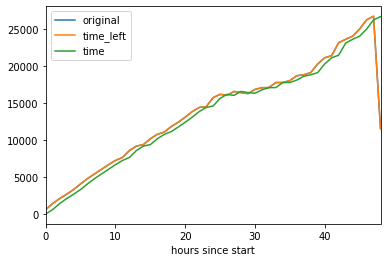

In [12]:
fig,ax=plt.subplots(1,1)
df_orig.plot(x='hours since start', y='sep', ax=ax,label='original')
df_time_left.plot(x='hours since start', y='sep', ax=ax,label= 'time_left')
df_time.plot(x='hours since start', y='sep', ax=ax, label='time')

Yes, they are the same...

Print the output to check

In [13]:
df_orig

time_since_start           sep  count  hours since start
0   0 days 00:00:00    584.433820    264                0.0
1   0 days 01:00:00   1400.646094    261                1.0
2   0 days 02:00:00   2074.120307    279                2.0
3   0 days 03:00:00   2658.992114    280                3.0
4   0 days 04:00:00   3292.774766    275                4.0
5   0 days 05:00:00   4057.388872    278                5.0
6   0 days 06:00:00   4769.640488    273                6.0
7   0 days 07:00:00   5406.735990    261                7.0
8   0 days 08:00:00   6021.499431    279                8.0
9   0 days 09:00:00   6652.725244    280                9.0
10  0 days 10:00:00   7217.520064    276               10.0
11  0 days 11:00:00   7631.130851    279               11.0
12  0 days 12:00:00   8555.680837    275               12.0
13  0 days 13:00:00   9163.437114    270               13.0
14  0 days 14:00:00   9365.730191    286               14.0
15  0 days 15:00:00  10153.648236    279               15.0
16  0 days 16:00:00  10748.952118    276               16.0
17  0 days 17:00:00  11059.663250    280               17.0
18  0 days 18:00:00  11802.974619    274               18.0
19  0 days 19:00:00  12385.198248    270               19.0
20  0 days 20:00:00  13074.171290    284               20.0
21  0 days 21:00:00  13818.027014    276               21.0
22  0 days 22:00:00  14389.453647    269               22.0
23  0 days 23:00:00  14487.018315    279               23.0
24  1 days 00:00:00  15709.200197    262               24.0
25  1 days 01:00:00  16157.421382    258               25.0
26  1 days 02:00:00  16014.068030    274               26.0
27  1 days 03:00:00  16550.805758    276               27.0
28  1 days 04:00:00  16396.483823    269               28.0
29  1 days 05:00:00  16249.904585    278               29.0
30  1 days 06:00:00  16821.997678    263               30.0
31  1 days 07:00:00  17059.334825    260               31.0
32  1 days 08:00:00  17073.816060    274               32.0
33  1 days 09:00:00  17755.304343    277               33.0
34  1 days 10:00:00  17750.863445    269               34.0
35  1 days 11:00:00  18017.101835    279               35.0
36  1 days 12:00:00  18672.133402    263               36.0
37  1 days 13:00:00  18800.480073    258               37.0
38  1 days 14:00:00  19097.803352    274               38.0
39  1 days 15:00:00  20263.966873    275               39.0
40  1 days 16:00:00  21098.608074    269               40.0
41  1 days 17:00:00  21382.829670    277               41.0
42  1 days 18:00:00  23133.589907    263               42.0
43  1 days 19:00:00  23594.491892    257               43.0
44  1 days 20:00:00  24009.668118    273               44.0
45  1 days 21:00:00  24966.848077    273               45.0
46  1 days 22:00:00  26217.775046    270               46.0
47  1 days 23:00:00  26710.742265    275               47.0
48  2 days 00:00:00  11525.505663      1               48.0

In [14]:
df_timedelta

time_since_start           sep  count  hours since start
0   0 days 00:00:00    584.433820    264                0.0
1   0 days 01:00:00   1400.646094    261                1.0
2   0 days 02:00:00   2074.120307    279                2.0
3   0 days 03:00:00   2658.992114    280                3.0
4   0 days 04:00:00   3292.774766    275                4.0
5   0 days 05:00:00   4057.388872    278                5.0
6   0 days 06:00:00   4769.640488    273                6.0
7   0 days 07:00:00   5406.735990    261                7.0
8   0 days 08:00:00   6021.499431    279                8.0
9   0 days 09:00:00   6652.725244    280                9.0
10  0 days 10:00:00   7217.520064    276               10.0
11  0 days 11:00:00   7631.130851    279               11.0
12  0 days 12:00:00   8555.680837    275               12.0
13  0 days 13:00:00   9163.437114    270               13.0
14  0 days 14:00:00   9365.730191    286               14.0
15  0 days 15:00:00  10153.648236    279               15.0
16  0 days 16:00:00  10748.952118    276               16.0
17  0 days 17:00:00  11059.663250    280               17.0
18  0 days 18:00:00  11802.974619    274               18.0
19  0 days 19:00:00  12385.198248    270               19.0
20  0 days 20:00:00  13074.171290    284               20.0
21  0 days 21:00:00  13818.027014    276               21.0
22  0 days 22:00:00  14389.453647    269               22.0
23  0 days 23:00:00  14487.018315    279               23.0
24  1 days 00:00:00  15709.200197    262               24.0
25  1 days 01:00:00  16157.421382    258               25.0
26  1 days 02:00:00  16014.068030    274               26.0
27  1 days 03:00:00  16550.805758    276               27.0
28  1 days 04:00:00  16396.483823    269               28.0
29  1 days 05:00:00  16249.904585    278               29.0
30  1 days 06:00:00  16821.997678    263               30.0
31  1 days 07:00:00  17059.334825    260               31.0
32  1 days 08:00:00  17073.816060    274               32.0
33  1 days 09:00:00  17755.304343    277               33.0
34  1 days 10:00:00  17750.863445    269               34.0
35  1 days 11:00:00  18017.101835    279               35.0
36  1 days 12:00:00  18672.133402    263               36.0
37  1 days 13:00:00  18800.480073    258               37.0
38  1 days 14:00:00  19097.803352    274               38.0
39  1 days 15:00:00  20263.966873    275               39.0
40  1 days 16:00:00  21098.608074    269               40.0
41  1 days 17:00:00  21382.829670    277               41.0
42  1 days 18:00:00  23133.589907    263               42.0
43  1 days 19:00:00  23594.491892    257               43.0
44  1 days 20:00:00  24009.668118    273               44.0
45  1 days 21:00:00  24966.848077    273               45.0
46  1 days 22:00:00  26217.775046    270               46.0
47  1 days 23:00:00  26710.742265    275               47.0
48  2 days 00:00:00  11525.505663      1               48.0

In [15]:
df_time

time_since_start           sep  count  hours since start
0   0 days 00:00:00      0.131081    1.0                0.0
1   0 days 01:00:00    586.655504  263.0                1.0
2   0 days 02:00:00   1400.646094  261.0                2.0
3   0 days 03:00:00   2074.120307  279.0                3.0
4   0 days 04:00:00   2658.992114  280.0                4.0
5   0 days 05:00:00   3292.774766  275.0                5.0
6   0 days 06:00:00   4061.327667  279.0                6.0
7   0 days 07:00:00   4768.218899  272.0                7.0
8   0 days 08:00:00   5406.735990  261.0                8.0
9   0 days 09:00:00   6021.499431  279.0                9.0
10  0 days 10:00:00   6652.725244  280.0               10.0
11  0 days 11:00:00   7217.520064  276.0               11.0
12  0 days 12:00:00   7631.130851  279.0               12.0
13  0 days 13:00:00   8555.680837  275.0               13.0
14  0 days 14:00:00   9163.437114  270.0               14.0
15  0 days 15:00:00   9365.730191  286.0               15.0
16  0 days 16:00:00  10153.648236  279.0               16.0
17  0 days 17:00:00  10748.952118  276.0               17.0
18  0 days 18:00:00  11120.959361  281.0               18.0
19  0 days 19:00:00  11742.605036  273.0               19.0
20  0 days 20:00:00  12385.198248  270.0               20.0
21  0 days 21:00:00  13074.171290  284.0               21.0
22  0 days 22:00:00  13818.027014  276.0               22.0
23  0 days 23:00:00  14389.453647  269.0               23.0
24  1 days 00:00:00  14585.834470  280.0               24.0
25  1 days 01:00:00  15607.873218  261.0               25.0
26  1 days 02:00:00  16157.421382  258.0               26.0
27  1 days 03:00:00  16014.068030  274.0               27.0
28  1 days 04:00:00  16550.805758  276.0               28.0
29  1 days 05:00:00  16396.483823  269.0               29.0
30  1 days 06:00:00  16305.712030  279.0               30.0
31  1 days 07:00:00  16764.752701  262.0               31.0
32  1 days 08:00:00  17059.334825  260.0               32.0
33  1 days 09:00:00  17073.816060  274.0               33.0
34  1 days 10:00:00  17755.304343  277.0               34.0
35  1 days 11:00:00  17750.863445  269.0               35.0
36  1 days 12:00:00  18088.591054  280.0               36.0
37  1 days 13:00:00  18598.232830  262.0               37.0
38  1 days 14:00:00  18800.480073  258.0               38.0
39  1 days 15:00:00  19097.803352  274.0               39.0
40  1 days 16:00:00  20263.966873  275.0               40.0
41  1 days 17:00:00  21098.608074  269.0               41.0
42  1 days 18:00:00  21444.709806  278.0               42.0
43  1 days 19:00:00  23074.613122  262.0               43.0
44  1 days 20:00:00  23594.491892  257.0               44.0
45  1 days 21:00:00  24009.668118  273.0               45.0
46  1 days 22:00:00  24966.848077  273.0               46.0
47  1 days 23:00:00  26217.775046  270.0               47.0
48  2 days 00:00:00  26655.723292  276.0               48.0

# Summary

I think what is happening is that when we resample using timedeltas, the timedelta is rounded down to the hour before the bins are determined. So we essentially lose control over specifying the end points of the bin. 

I think it makes most sense to bin like this : (0 hour, 1 hour], (1 hour, 2 hour] for a few reasons.
1. We don't want to include the initial position in the statistics of hour 1. So the hour 1 average includes everything up to and including hour 1 but does not include the initial position which should have a perfect score (or nearly perfect depending on rounding differences)
2. We want to include the statistis at hour 48 if it exists. But as we have seen, it is very rare to have the observation end exactly on the 48th hour. So we want to clump these rare cases in the 47 to 48 hour bin.

Other options are
1. Centre the bins on the hour and calculate the mean: [0.5, 1.5), [1.5, 2.5) etc. 
2. Some kind of interpolation although this is strange given we are taking multiple tracks that aren't connected in time. 

Another observation:
* The results would be much less difficult to interpret if we have regularly spaced observations (say on the hour) or we interpolate everything to the model output times (which are generally on the hour. 

# Conclusions
Use the `bin_skills_time()` function (or something similar) in our analysis.

I also added a count to the data frame to help interpret the results.

I'm note sure the base argumnet is needed in that functio.